<a href="https://colab.research.google.com/github/CCanxue/CCanxue/blob/main/softmax%E5%9B%9E%E5%BD%92%E7%9A%84%E4%BB%8E%E9%9B%B6%E5%AE%9E%E7%8E%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install d2l

     |████████████████████████████████| 82 kB 204 kB/s 
     |████████████████████████████████| 9.9 MB 21.9 MB/s 
     |████████████████████████████████| 61 kB 1.1 MB/s 
     |████████████████████████████████| 10.3 MB 32.1 MB/s 
     |████████████████████████████████| 82 kB 524 kB/s 
     |████████████████████████████████| 11.6 MB 3.7 MB/s 
     |████████████████████████████████| 20.1 MB 63.6 MB/s 
     |████████████████████████████████| 9.9 MB 34.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplo

In [19]:
a=zip((0,0),[100,200])

c=[e+b for e,b in a]
f=zip(c,[500,600])
c=[e+b for e,b in f]
print(c)

[600, 800]


In [2]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
from IPython import display
d2l.use_svg_display()
#读取数据集
trans=transforms.ToTensor()
mnist_train=torchvision.datasets.FashionMNIST(root="../data",train=True,transform=trans,download=True)
mnist_test=torchvision.datasets.FashionMNIST(root="../data",train=False,transform=trans,download=True)
'''def get_fasion_mnist_labels(labels):
  text_labels=['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
  return [text_labels[int(i)] for i in labels]
def show_images(imgs,num_rows,num_cols,titles=None,scale=1.5):
  figsize=(num_cols*scale,num_rows*scale)
  _,axes=d2l.plt.subplots(num_rows,num_cols,figsize=figsize)
  axes=axes.flatten()
  for i,(ax,img) in enumerate(zip(axes,imgs)):
    if torch.is_tensor(img):
      ax.imshow(img.numpy())
    else:
      ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles :
      ax.set_title(titles[i])
  return axes
x,y=next(iter(data.DataLoader(mnist_train,batch_size=18)))
show_images(x.reshape(18,28,28),2,9,titles=get_fasion_mnist_labels(y))'''
batch_size=256
data.DataLoader(mnist_train,batch_size,num_workers=2)
def load_data_fashion_mnist(batch_size,resize=None):
  trans=[transforms.ToTensor()]
  if resize:
    trans.insert(0,transforms.Resize(resize)) #改变图像大小，插入到变换列表中
  trans=transforms.Compose(trans) #对象为多个变换组成的列表，返回他们的组合  这里有两个变换，分别为原有的ToTensor和插入的Resize
  mnist_train=torchvision.datasets.FashionMNIST(root="../data",train=True,transform=trans,download=True)
  mnist_test=torchvision.datasets.FashionMNIST(root="../data",train=False,transform=trans,download=True)
  return ((data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=0)),
      (data.DataLoader(mnist_test,batch_size,shuffle=True,num_workers=0)))
train_iter,test_iter=load_data_fashion_mnist(60) #
print(len(mnist_test))
print(len(test_iter)) #共有167个batch，每个batch为60(除了最后一个为40),故长度为167
for x,y in train_iter: #只有1个batch大小？？？
  print(x.shape,x.dtype,y.shape,y.dtype)
  break
#初始化模型参数
num_inputs=784
num_outputs=10
w=torch.normal(0,0.01,(num_inputs,num_outputs),requires_grad=True)
b=torch.zeros(num_outputs,requires_grad=True)
#定义softmax操作
def softmax(x):
  x_exp=torch.exp(x)
  partition=x_exp.sum()
  return x_exp/partition
def net(x):
  return softmax(torch.matmul(x.reshape((-1,w.shape[0])),w)+b)
y=torch.tensor([0,2])
y_hat=torch.tensor([[0.1,0.3,0.6], [0.3,0.2,0.5]])
#print(y_hat[[0,1],y]) #不太理解
def cross_entropy(y_hat,y):
  return -torch.log(y_hat[range(len(y_hat)),y])
def accuracy(y_hat,y):
  y_hat=y_hat.argmax(dim=1)
  c=y_hat==y
  return float(c.sum()) #预测正确的数据数
class Accumulator:
  def __init__(self,n):
    self.data=[0]*n
  def add(self,*args): #*将输入数据变为元组
    self.data=[a+float(b) for a,b in zip(self.data,args)] #zip将输入的可迭代对象按位置变为元组 每次循环调用原先的self.data实现累加
  def reset(self):
    self.data=[0]*len(self.data)
  def __getitem__(self,idx): #当对象做[]运算时调用该方法
    return self.data[idx]
def evaluate_accuracy(net,data_iter):
  if isinstance(net,torch.nn.Module): #判断net是否为torch.nn.Module及其子类的对象
    net.eval() #测试中必须写  评估模式干啥用的
  metric=Accumulator(2)
  with torch.no_grad():
    for x,y in data_iter: 
      metric.add(accuracy(net(x),y),y.numel())    
  return metric[0]/metric[1]
print(evaluate_accuracy(net,test_iter))
print(x.shape[0])
#训练
def train_epoch_ch3(net,train_iter,loss,updater):
  if isinstance(net,torch.nn.Module):
    net.train()
  metric=Accumulator(3)
  for x,y in train_iter:
    y_hat=net(x)
    l=loss(y_hat,y)
    if isinstance(updater,torch.optim.Optimizer):
      updater.zero_grad() #清除以前的梯度
      l.mean().backward()
      updater.step() #进行单次优化
    else:
      l.sum().backward()
      updater(x.shape[0]) #不太懂
    metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
  return metric[0]/metric[2],metric[1]/metric[2] #训练损失和训练精度

10000
167
torch.Size([60, 1, 28, 28]) torch.float32 torch.Size([60]) torch.int64
0.1545
60


In [3]:
class Animator:
  def __init__(self,xlabel=None,ylabel=None,legend=None,xlim=None,ylim=None,xscale="linear",yscale="linear",fmts=('-','m--','g-.','r:'),nrows=1,ncols=1,figsize=(3.5,2.5)):
    if legend is None:
      legend=[]
    d2l.use_svg_display()
    self.fig,self.axes=d2l.plt.subplots(nrows,ncols,figsize=figsize)
    if nrows*ncols==1:
      self.axes=[self.axes,]
    self.config_axes=lambda:d2l.set_axes(self.axes[0],xlabel,ylabel,xlim,ylim,xscale,yscale,legend)
    self.X,self.Y,self.fmts = None,None,fmts
  def add(self,x,y):
    if not hasattr(y,"__len__"):
      y=[y]
    n=len(y)
    if not hasattr(x,"__len__"):
      x=[x]*n
    if not self.X:
      self.X=[[] for _ in range(n)]
    if not self.Y:
      self.Y=[[] for _ in range(n)]
    for i,(a,b) in enumerate(zip(x,y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x,y,fmt in zip(self.X,self.Y,self.fmts):
      self.axes[0].plot(x,y,fmt)
    self.config_axes()
    display.display(self.fig)
    display.clear_output(wait=True)

(4.808378588358561, 0.82345, 0.8197)

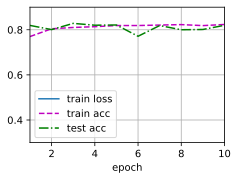

In [4]:
def train_ch3(net,train_iter,test_iter,loss,nums_epochs,updater):
  animator = Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0.3,0.9],legend=['train loss','train acc','test acc'])
  for epoch in range(num_epochs):
    train_metrics=train_epoch_ch3(net,train_iter,loss,updater)
    test_acc=evaluate_accuracy(net,test_iter)
    animator.add(epoch + 1, train_metrics + (test_acc,))
  train_loss,train_acc=train_metrics
  assert train_loss<5,train_loss #为什么这么大
  assert train_acc<=1 and train_acc>0.7,train_acc
  assert test_acc<=1 and test_acc>0.7,test_acc
  return train_loss,train_acc,test_acc
lr=0.1
def updater(batch_size):
  return d2l.sgd([w,b],lr,batch_size)
num_epochs=10
train_ch3(net,train_iter,test_iter,cross_entropy,num_epochs,updater) #为什么不出现train loss的图像

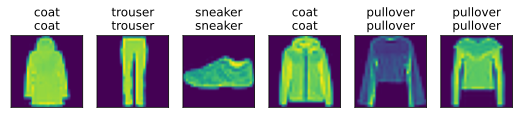

In [5]:
#预测
def predict_ch3(net,test_iter,n=6):
  for x,y in test_iter:
    break
  trues=d2l.get_fashion_mnist_labels(y)
  preds=d2l.get_fashion_mnist_labels(net(x).argmax(axis=1))
  titles=[true+'\n'+pred for true,pred in zip(trues,preds)]
  d2l.show_images(x[0:n].reshape((n,28,28)),1,n,titles=titles[0:n])
predict_ch3(net,test_iter)